In [1]:
import os
import time
import datetime
from tqdm.notebook import tqdm
import re
import numpy as np
import pandas as pd
import seaborn as sns; sns.set() # sns.set() ==> グラフの見た目をseabornに合わせる
from collections import Counter
from sklearn import preprocessing
import pickle

import lightgbm as lgb
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score

import optuna.integration.lightgbm as lgb_o

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import mysql.connector

session = mysql.connector.connect(
      host='localhost',
      port='3307',
      user='USER',
      password='PASSWORD',
      database='DB_NAME'
  )

# コネクションが切れた時に再接続してくれるよう設定
session.ping(reconnect=True)

# 接続できているかどうか確認
print(session.is_connected())

# DB操作用にカーソルを作成
cur = session.cursor()

True


In [3]:
cur.execute("SELECT * FROM horse_seiseki WHERE (year >= 15 and year <= 21) ORDER BY race_id ASC")
rows = cur.fetchall()
#for row in rows:
#    print('data=', row)
cols =  ['id', '年', '月', '日', '日付S', '回次', '場所', '日次', '発走時刻', 'レース番号', 'レースID',
       '略レース名', 'クラスコード', '芝・ダ', 'トラックコード', 'コーナー回数', '距離', 'コース区分', '馬場状態',
       '天候', '馬名', '性別', '年齢', '騎手', '斤量', 'ブリンカー', '頭数', '枠番', '馬番', '入先着順',
       '異常コード', '確定着順', '着差タイム', '人気', '走破タイム秒', 'タイムS', '補正タイム', '補9',
       '通過順1角', '通過順2角', '通過順3角', '通過順4角', '脚質', '上がり3F', '馬体重', '増減', '調教師',
       '所属', '賞金', '血統登録番号', '騎手コード', '調教師コード', '馬主名', '生産者名', '父馬名', '母馬名',
       '母の父名', '毛色', '生年月日', '単勝オッズ', 'PCI', 'RPCI', 'PCI3', 'Ave-3F', 'レース名',
       '年齢限定競走種別コード', '競走記号コード', '重量コード', '1着本賞金', 'race_id', 'ZI',
       'レース間隔_週', 'jocky_weight_diff', 'created_at', 'updated_at']
ddd = pd.DataFrame(rows, columns=cols)
ddd

,id,年,月,日,日付S,回次,場所,日次,発走時刻,レース番号,...,年齢限定競走種別コード,競走記号コード,重量コード,1着本賞金,race_id,ZI,レース間隔_週,jocky_weight_diff,created_at,updated_at
0,199438,15,1,4,2015.1.4,1,中山,1,09:50,1,...,12,003,3,500,2015010406010101,89,5,0.0,2022-04-04 16:14:17,2022-04-04 16:14:17
1,199439,15,1,4,2015.1.4,1,中山,1,09:50,1,...,12,003,3,500,2015010406010101,105,19,0.0,2022-04-04 16:14:18,2022-04-04 16:14:18
2,199440,15,1,4,2015.1.4,1,中山,1,09:50,1,...,12,003,3,500,2015010406010101,102,5,1.0,2022-04-04 16:14:07,2022-04-04 16:14:07
3,199441,15,1,4,2015.1.4,1,中山,1,09:50,1,...,12,003,3,500,2015010406010101,111,4,1.0,2022-04-04 16:14:31,2022-04-04 16:14:31
4,199442,15,1,4,2015.1.4,1,中山,1,09:50,1,...,12,003,3,500,2015010406010101,113,3,1.0,2022-04-04 16:14:11,2022-04-04 16:14:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341656,583956,21,12,28,2021.12.28,6,阪神,9,16:25,12,...,13,A00,1,1820,2021122809060912,106,2,-1.0,2022-04-04 16:16:25,2022-04-04 16:16:25
341657,583957,21,12,28,2021.12.28,6,阪神,9,16:25,12,...,13,A00,1,1820,2021122809060912,103,6,0.0,2022-04-04 16:17:03,2022-04-04 16:17:03
341658,583958,21,12,28,2021.12.28,6,阪神,9,16:25,12,...,13,A00,1,1820,2021122809060912,102,13,-2.0,2022-04-04 16:16:28,2022-04-04 16:16:28
341659,583959,21,12,28,2021.12.28,6,阪神,9,16:25,12,...,13,A00,1,1820,2021122809060912,103,11,-1.0,2022-04-04 16:17:02,2022-04-04 16:17:02


In [17]:
# 生産者　ノーザンファームを調べてみる
ddd['生産者名'].shape #-> 215760
ddd['生産者名'].value_counts().sort_values(ascending=False).head(20) # 生産者上位20位
ddd.loc[ddd['生産者名']=='ノーザンファーム', ['馬主名', '調教師', '生産者名', '確定着順', '単勝オッズ']].head(10) # NF全体では 22489
#print("ノーザンファーム生産馬の割合", 22489/215760) # ノーザンファームは全体の10%程の生産


,馬主名,調教師,生産者名,確定着順,単勝オッズ
60,吉田勝己,木村哲也,ノーザンファーム,5,3.7
69,シルクレーシング,加藤征弘,ノーザンファーム,3,7.4
88,シルクレーシング,萩原清,ノーザンファーム,3,4.2
113,松本俊廣,勢司和浩,ノーザンファーム,16,206.2
123,金子真人ホールディングス,国枝栄,ノーザンファーム,4,22.0
139,星野壽市,手塚貴久,ノーザンファーム,3,5.8
142,金子真人ホールディングス,池江泰寿,ノーザンファーム,1,6.1
145,吉田勝己,平田修,ノーザンファーム,3,7.5
157,金子真人ホールディングス,友道康夫,ノーザンファーム,4,94.4
159,島川隆哉,鈴木康弘,ノーザンファーム,10,14.3


In [52]:
#ddd['生産者名'].unique() # 生産者数
#ddd['生産者名'].value_counts().head(50)
farm = ddd['生産者名'].value_counts()
#farm.index[:10]
farm.head()

ノーザンファーム            34967
社台ファーム              26808
社台コーポレーション白老ファーム     8398
岡田スタツド               5784
下河辺牧場                5637
Name: 生産者名, dtype: int64

In [63]:
#farm1 = ddd.loc[ddd['確定着順']==1, ['生産者名']].value_counts()
farm1 = ddd[ddd['確定着順']==1]['生産者名'].value_counts()
farm1

ノーザンファーム                                             4263
社台ファーム                                               2225
社台コーポレーション白老ファーム                                      717
ダーレー・ジャパン・ファーム                                        502
下河辺牧場                                                 439
                                                     ... 
田渕牧場                                                    1
坂元牧場                                                    1
George Waggoner Stables Inc.                            1
William Duignan & Tranquility Investments Limited       1
西野春樹                                                    1
Name: 生産者名, Length: 1170, dtype: int64

numpy.ndarray

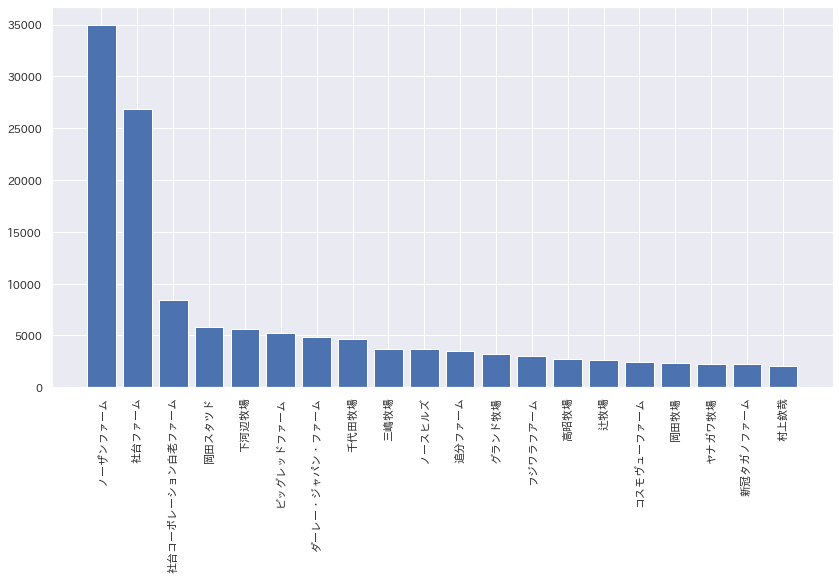

In [64]:
x = farm.index[:20]
y = farm.values[:20]
plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
plt.bar(x, y)
type(y)


<BarContainer object of 20 artists>

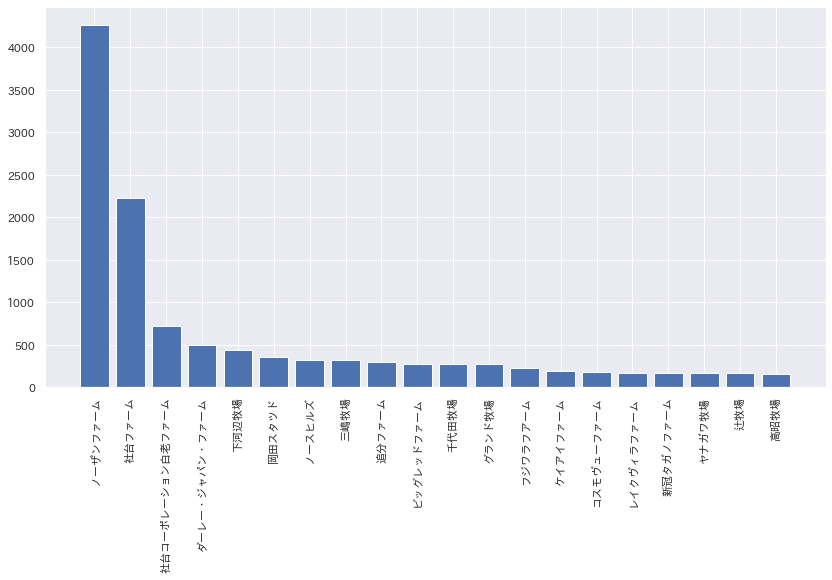

In [65]:
x = farm1.index[:20]
y = farm1.values[:20]
plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
plt.bar(x, y)

In [6]:
length = ddd.shape[0]
print('全体数：', length)
#ddd['生産者名'].value_counts().cumsum().head(50)
#ddd.groupby('生産者名').groups.keys()

全体数： 341661


In [7]:
ddd['1着本賞金'].expanding().agg(["mean", "std"])
#ddd['1着本賞金'].expanding().mean()  # 移動和 cumsumでも良い
#ddd['1着本賞金'].expanding().std()

,mean,std
0,500.000000,NaN
1,500.000000,0.000000
2,500.000000,0.000000
3,500.000000,0.000000
4,500.000000,0.000000
...,...,...
341656,1067.249712,1414.587034
341657,1067.251916,1414.585550
341658,1067.254119,1414.584066
341659,1067.256322,1414.582582


In [8]:
pu = ddd.loc[ddd['生産者名']=='ノーザンファーム', ['馬主名', '調教師', '生産者名', '確定着順', '単勝オッズ']]
pu

,馬主名,調教師,生産者名,確定着順,単勝オッズ
60,吉田勝己,木村哲也,ノーザンファーム,5,3.7
69,シルクレーシング,加藤征弘,ノーザンファーム,3,7.4
88,シルクレーシング,萩原清,ノーザンファーム,3,4.2
113,松本俊廣,勢司和浩,ノーザンファーム,16,206.2
123,金子真人ホールディングス,国枝栄,ノーザンファーム,4,22.0
...,...,...,...,...,...
341628,キャロットファーム,池江泰寿,ノーザンファーム,6,3.1
341630,金子真人ホールディングス,国枝栄,ノーザンファーム,9,16.1
341648,吉田勝己,浅見秀一,ノーザンファーム,5,29.4
341651,林正道,浅見秀一,ノーザンファーム,13,49.6


In [9]:
#grouped = ddd.groupby(['生産者名', '馬主名'], as_index=False)[['確定着順', '人気', '1着本賞金']]
grouped = ddd.groupby('生産者名')[['確定着順', '人気', '単勝オッズ', '1着本賞金', '馬名']]
grouped.agg(['mean', 'std']).tail(20)

確定着順                   人気                   単勝オッズ              \
             mean       std       mean         std        mean         std   
生産者名                                                                         
高瀬敦      6.770492  4.192825   8.327869    4.592462   93.885246  123.180998   
高瀬牧場     7.335766  4.435583   4.062044   60.965430   56.961679   77.950810   
高田利雄    10.750000  2.872281   8.500000    1.914854  107.850000  144.228280   
高田良一     9.666667  3.807887  13.222222    3.898005  267.611111  223.205250   
高藤茂     13.500000  2.828427  14.000000    2.878492  275.675000   90.008916   
高野牧場     7.980328  4.354324   5.442623   57.872286   75.934754   94.979441   
鮫川フアーム   9.058559  4.240634   1.342342   95.675781  121.469820  116.881573   
鮫川啓一     7.905303  4.495805   6.526515   36.039721   63.217551   93.399623   
鮫川牧場    15.000000       NaN  15.000000         NaN  100.500000         NaN   
鳥井征士     6.909091  4.667413  -4.000000  107.386187   52.951136   88.838224   
鳥井牧場     8.473684  4.496448   8.456140    4.758714   75.982456  105.005874   
鳥谷勝彦     8.727273  4.036828 -13.227273  152.114532  110.761364  157.726319   
鵜木唯義     9.085271  4.292128  10.000000    4.063942  104.727907  109.422186   
鹿嶋牧場     8.552632  4.285093   8.868421    4.467123  109.560526  117.707026   
鹿戸和幸    11.360000  3.751444  11.080000    3.094619  138.172000   96.120209   
鹿戸正幸    10.361446  4.495467  10.710843    4.720299  137.415663  140.882670   
鹿戸武光    13.666667  1.861899  14.833333    0.983192  310.700000   76.101406   
鹿戸美明    10.280000  2.776689  10.280000    3.360556  159.640000  117.455367   
鹿戸辰幸    14.500000  2.509980  13.333333    1.966384  196.366667  139.061047   
黒川賢司     8.333333  3.559026  10.666667    2.503331  126.450000  110.086416   

              1着本賞金               
               mean          std  
生産者名                              
高瀬敦      854.098361   346.734178  
高瀬牧場     820.401460   484.172402  
高田利雄     580.000000   104.562581  
高田良一     546.666667    87.034476  
高藤茂      525.000000    70.710678  
高野牧場     856.459016   578.615566  
鮫川フアーム   619.144144   193.324539  
鮫川啓一     829.406566   700.790975  
鮫川牧場    2200.000000          NaN  
鳥井征士    1106.477273   896.705387  
鳥井牧場     919.473684   330.677989  
鳥谷勝彦     672.272727   224.072908  
鵜木唯義    1367.403101  1754.729224  
鹿嶋牧場     586.842105   126.514720  
鹿戸和幸     562.800000    90.669730  
鹿戸正幸     612.530120   158.313084  
鹿戸武光     550.000000    83.666003  
鹿戸美明     622.000000   119.617446  
鹿戸辰幸     570.000000   100.796825  
黒川賢司     476.666667    29.439203

In [10]:
#grouped.groups
#grouped.size()
#grouped.transform('count')
northern_farm = grouped.get_group('ノーザンファーム')
northern_farm.loc[northern_farm['確定着順']==2, ['確定着順', '人気', '単勝オッズ', '1着本賞金', '馬名']].agg(['mean', 'std'])

,確定着順,人気,単勝オッズ,1着本賞金
mean,2.0,3.272877,8.939819,1465.105798
std,0.0,2.525518,13.323833,2137.320831


In [11]:
# northern_farm['人気'].unique() # 人気に-999を入力している
northern_farm['人気'].value_counts()
northern_farm.loc[northern_farm['人気'] != -999,  ['確定着順', '人気', '単勝オッズ', '馬名']].sort_values('確定着順')

,確定着順,人気,単勝オッズ,馬名
293644,0,9,33.1,ブラストワンピース
33668,0,7,23.7,ハッピーパウダー
11904,0,14,229.6,グラスリード
279885,0,10,33.8,トライフォーリアル
116288,0,1,2.4,ダローネガ
...,...,...,...,...
240889,18,12,53.4,ヴェロニカグレース
268169,18,11,87.8,フィオナサンライズ
85950,18,1,2.9,ヴィンテージローズ
304554,18,16,200.0,フェアリーテイル


In [12]:
northern_farm.drop(947).head(3)

,確定着順,人気,単勝オッズ,1着本賞金,馬名
60,5,2,3.7,500,ディリジェンテ
69,3,4,7.4,750,ロレーヌクロス
88,3,1,4.2,750,サヴァティアーノ


In [13]:
for k, horse in northern_farm.iterrows():
    if horse['確定着順'] == 0:
        northern_farm.drop(index=k, inplace=True)
    
northern_farm['確定着順'].value_counts()

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1     4263
2     3639
3     3249
4     2917
5     2682
6     2599
7     2333
8     2166
9     2002
10    1811
11    1554
12    1376
13    1237
14    1053
15     881
16     637
17     194
18     117
Name: 確定着順, dtype: int64

In [15]:
#northern_farm.loc[northern_farm['人気']==4, ['確定着順', '人気', '単勝オッズ', '1着本賞金']].agg(['mean', 'std'])
northern_farm.loc[northern_farm['単勝オッズ']<5.0, ['確定着順', '人気', '単勝オッズ', '1着本賞金']].agg(['mean', 'std'])

,確定着順,人気,単勝オッズ,1着本賞金
mean,3.704211,1.530049,3.160057,1372.830131
std,3.097086,0.665682,1.024156,2076.369041


In [77]:
# https://ja.wikipedia.org/wiki/%E4%B8%80%E5%8F%A3%E9%A6%AC%E4%B8%BB　を参考にしました。

club_name = [
 'ウイン',
 'キャロットファーム',
 'グリーンファーム',
 'ゴールドレーシング',
 'ライオンレースホース',
 '社台レースホース',
 'サンデーレーシング',
 'シルクレーシング',
 'G1レーシング',
 'ターフ・スポート',
 '大樹ファーム',
 'DMMドリームクラブ',
 '東京ホースレーシング',
 '京都ホースレーシング',
 'ノルマンディーサラブレッドレーシング',
 '広尾レース',
 '友駿ホースクラブ',
 'ヒダカ・ブリーダーズ・ユニオン',
 'サラブレッドクラブ・ラフィアン',
 'ロードホースクラブ',
 'ローレルレーシング',
 'YGGホースクラブ',
 'フクキタル'
]

ddd['club_owner_horse'] = ddd['馬主名'].map( lambda x: x in club_name ).map(lambda y: 1 if y is True else 0)
#ddd.to_csv('club_owner.csv', columns=['馬主名', 'club_owner_horse'], header=True, index=False)
ddd.loc[ddd['club_owner_horse']==1, ['馬名', '馬主名']]

,馬名,馬主名
12,ハルダヨリ,ヒダカ・ブリーダーズ・ユニオン
20,ロードトリニティ,ロードホースクラブ
25,マイネルシュプレム,サラブレッドクラブ・ラフィアン
31,マイネルヴォーダン,サラブレッドクラブ・ラフィアン
37,トゥルーウインド,社台レースホース
...,...,...
341628,アステロイドベルト,キャロットファーム
341633,エブリワンブラック,DMMドリームクラブ
341650,ローレルアイリス,ローレルレーシング
341654,ミニオンペール,ノルマンディーサラブレッドレーシング


In [33]:
# 全体で何割？
owner = ddd['club_owner_horse'].value_counts()
owner.loc[1] / (owner.loc[0]+owner.loc[1])
#owner
#ddd.query('club_owner_horse==1')['馬主名'].unique()

0.1697062292740465

In [34]:
ddd['club_owner_horse'].value_counts().sort_index(ascending=False)

1     57982
0    283679
Name: club_owner_horse, dtype: int64

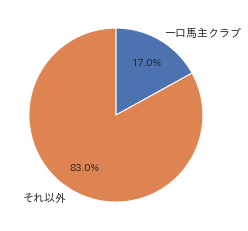

In [35]:
label = ['一口馬主クラブ', 'それ以外']
 
plt.pie(ddd['club_owner_horse'].value_counts().sort_index(ascending=False),
       labels=label, counterclock=False, startangle=90,
       autopct='%1.1f%%', pctdistance=0.7)
 
plt.show()

In [37]:
df_club = ddd[['club_owner_horse',
                      '馬主名',
                      '馬名',
                      '確定着順',
                      '人気',
                      '単勝オッズ',
                      '賞金',
                      '騎手',
                      '調教師',
                      '所属',
                      'レースID', '略レース名']]
df_club = df_club.query('club_owner_horse==1')
df_club

,club_owner_horse,馬主名,馬名,確定着順,人気,単勝オッズ,賞金,騎手,調教師,所属,レースID,略レース名
12,1,ヒダカ・ブリーダーズ・ユニオン,ハルダヨリ,5,6,9.1,50,大野拓弥,清水英克,美,201501040601010113,未勝利
20,1,ロードホースクラブ,ロードトリニティ,11,11,81.6,0,西田雄一,菊川正達,美,201501040601010205,未勝利
25,1,サラブレッドクラブ・ラフィアン,マイネルシュプレム,16,16,338.9,0,嘉藤貴行,黒岩陽一,美,201501040601010210,未勝利
31,1,サラブレッドクラブ・ラフィアン,マイネルヴォーダン,3,4,12.3,130,柴田大知,伊藤圭三,美,201501040601010216,未勝利
37,1,社台レースホース,トゥルーウインド,4,2,3.3,90,Ｃ．デム,田中剛,美,201501040601010306,新馬
...,...,...,...,...,...,...,...,...,...,...,...,...
341628,1,キャロットファーム,アステロイドベルト,6,1,3.1,0,松山弘平,池江泰寿,栗,202112280906091010,フォーチ･2勝
341633,1,DMMドリームクラブ,エブリワンブラック,0,11,29.3,0,藤岡康太,武幸四郎,栗,202112280906091112,ベテルギ(L)
341650,1,ローレルレーシング,ローレルアイリス,1,9,24.6,1820,川又賢治,杉山佳明,栗,202112280906091206,ファイＨ･3勝
341654,1,ノルマンディーサラブレッドレーシング,ミニオンペール,9,13,41.5,0,黛弘人,小手川準,美,202112280906091210,ファイＨ･3勝


馬主名
サンデーレーシング             6802.0
社台レースホース              6711.0
キャロットファーム             6385.0
サラブレッドクラブ・ラフィアン       6336.0
シルクレーシング              5590.0
G1レーシング               3338.0
ウイン                   3099.0
ノルマンディーサラブレッドレーシング    3035.0
東京ホースレーシング            3027.0
ヒダカ・ブリーダーズ・ユニオン       2830.0
ロードホースクラブ             2196.0
グリーンファーム              1692.0
ライオンレースホース            1417.0
ターフ・スポート              1183.0
友駿ホースクラブ               989.0
ローレルレーシング              931.0
大樹ファーム                 706.0
広尾レース                  650.0
DMMドリームクラブ             346.0
YGGホースクラブ              328.0
フクキタル                  190.0
京都ホースレーシング             176.0
ゴールドレーシング               25.0
Name: count, dtype: float64


<BarContainer object of 23 artists>

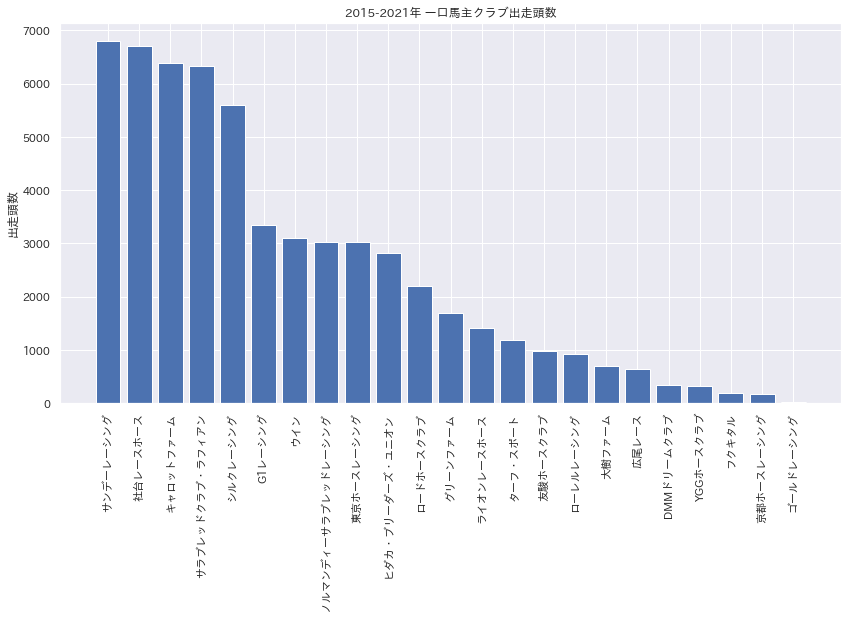

In [41]:
xcount = df_club.groupby('馬主名')['club_owner_horse'].describe()['count'].sort_values(ascending=False)
print(xcount)
x = xcount.values
i = xcount.index
plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
plt.grid(True) # グリッドを表示
plt.ylabel('出走頭数') # Y軸ラベル
#_, ax = plt.subplots()
#ax.set_xticks(x)
plt.title('2015-2021年 一口馬主クラブ出走頭数')
plt.bar(i, x)

In [42]:
first_point = df_club[df_club['確定着順']==1]
one_grouped = first_point.groupby('馬主名')
one_grouped.sum().sort_values('確定着順', ascending=False)

,club_owner_horse,確定着順,人気,単勝オッズ,賞金,レースID
馬主名,,,,,,
サンデーレーシング,895.0,895.0,2202.0,5247.7,1367395.0,1.806215e+20
キャロットファーム,827.0,827.0,2028.0,4804.8,1189540.0,1.668913e+20
シルクレーシング,694.0,694.0,1682.0,4058.2,989945.0,1.400686e+20
社台レースホース,668.0,668.0,1841.0,4883.8,736685.0,1.348067e+20
サラブレッドクラブ・ラフィアン,363.0,363.0,1530.0,4979.4,366600.0,7.324505e+19
G1レーシング,326.0,326.0,983.0,2599.2,356115.0,6.579197e+19
東京ホースレーシング,320.0,320.0,856.0,2182.2,366250.0,6.457534e+19
ウイン,226.0,226.0,879.0,2531.2,273100.0,4.560579e+19
ノルマンディーサラブレッドレーシング,204.0,204.0,743.0,1954.8,220000.0,4.117320e+19


In [39]:
#grouped = df_club.groupby('馬主名')
#print(grouped)
#print(grouped.count().sort_values('人気', ascending=False))
#print(grouped.sort_values('単勝オッズ', ascending=False))
#grouped.cumcount()
# １着の馬だけ抽出
#first = df_club[df_club['club_owner_horse'] == 1]
first_point = df_club[df_club['確定着順']==1] # -> 4511
#print('1着数: {}'.format(first_point.shape[0]))
one_grouped = first_point.groupby('馬主名')
data = one_grouped.sum().sort_values('確定着順', ascending=False)
ustuwa = pd.DataFrame()
ustuwa['1着数'] = data['確定着順'].astype(int)
ustuwa['1着数累計'] = data.cumsum()['確定着順'].astype(int)
ustuwa['1着数累計割合'] = data.cumsum()['確定着順'] / len(first_point)
ustuwa['賞金'] = data['賞金'].astype(int)
ustuwa['賞金平均'] = data['賞金'] / data['確定着順']
ustuwa.head(15)

,1着数,1着数累計,1着数累計割合,賞金,賞金平均
馬主名,,,,,
サンデーレーシング,895,895,0.164280,1367395,1527.815642
キャロットファーム,827,1722,0.316079,1189540,1438.379686
シルクレーシング,694,2416,0.443465,989945,1426.433718
社台レースホース,668,3084,0.566079,736685,1102.821856
サラブレッドクラブ・ラフィアン,363,3447,0.632709,366600,1009.917355
G1レーシング,326,3773,0.692548,356115,1092.377301
東京ホースレーシング,320,4093,0.751285,366250,1144.531250
ウイン,226,4319,0.792768,273100,1208.407080
ノルマンディーサラブレッドレーシング,204,4523,0.830213,220000,1078.431373


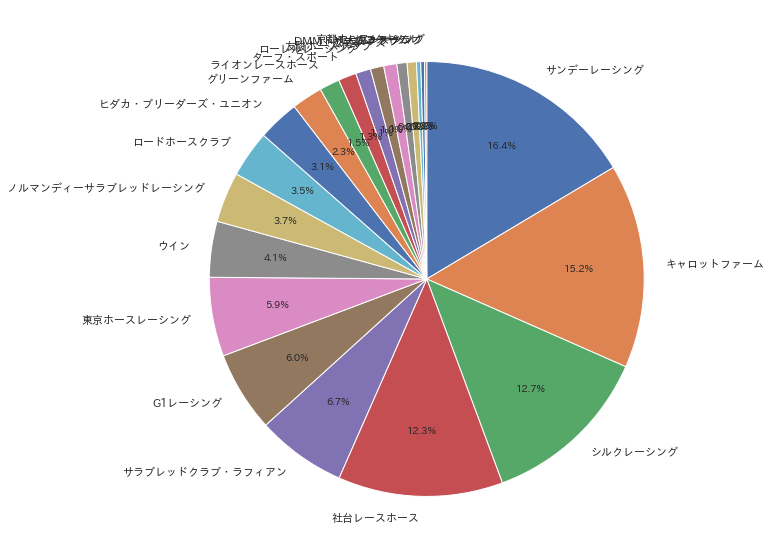

In [43]:
label = list(ustuwa.index.values)

plt.figure(figsize=(10,10))
plt.pie(ustuwa['1着数'], counterclock=False, startangle=90,
      labels=label, autopct='%1.1f%%', pctdistance=0.7)

#plt.legend()
plt.show()

In [44]:
one_grouped.sum()

,club_owner_horse,確定着順,人気,単勝オッズ,賞金,レースID
馬主名,,,,,,
DMMドリームクラブ,41.0,41.0,99.0,230.0,50490.0,8.281851e+18
G1レーシング,326.0,326.0,983.0,2599.2,356115.0,6.579197e+19
YGGホースクラブ,15.0,15.0,75.0,263.6,12080.0,3.030881e+18
ウイン,226.0,226.0,879.0,2531.2,273100.0,4.560579e+19
キャロットファーム,827.0,827.0,2028.0,4804.8,1189540.0,1.668913e+20
グリーンファーム,125.0,125.0,477.0,1445.4,117360.0,2.521945e+19
サラブレッドクラブ・ラフィアン,363.0,363.0,1530.0,4979.4,366600.0,7.324505e+19
サンデーレーシング,895.0,895.0,2202.0,5247.7,1367395.0,1.806215e+20
シルクレーシング,694.0,694.0,1682.0,4058.2,989945.0,1.400686e+20


In [45]:
data_count = len(df_club[df_club['club_owner_horse'] == 1]) # -> 47620
grouped = df_club[df_club['club_owner_horse'] == 1].groupby('馬主名')
best_3 = df_club[df_club['club_owner_horse'] == 1]

best_3 = best_3[best_3['確定着順']<=3] # -> 12539
three_grouped = best_3.groupby('馬主名')
data = three_grouped.count().sort_values('確定着順', ascending=False)
ustuwa = pd.DataFrame()
ustuwa['着順'] = data.cumsum()['確定着順']
ustuwa['rate'] = data.cumsum()['確定着順'] / len(best_3)
ustuwa['複勝'] = three_grouped.count()['確定着順']
ustuwa.head(18)

,着順,rate,複勝
馬主名,,,
サンデーレーシング,2320,0.148842,2320
キャロットファーム,4461,0.286200,2141
社台レースホース,6424,0.412138,1963
シルクレーシング,8219,0.527298,1795
サラブレッドクラブ・ラフィアン,9547,0.612498,1328
G1レーシング,10476,0.672099,929
東京ホースレーシング,11320,0.726246,844
ウイン,11999,0.769808,679
ノルマンディーサラブレッドレーシング,12652,0.811702,653
